*This is abridged version of the code used to complete this project. All you will have to changed to get this all to run is the file path locations for the letter and word data.*

# Importing Libraries

In [2]:
#This is used for deploying the model to the Apple Watch
#pip install coremltools

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
import time
import random
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.preprocessing import sequence
from tensorflow.keras import layers, models

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

#Hiding future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#pyts - Used for creating multivariate time series models
from pyts.classification import KNeighborsClassifier #KNN classifier
from pyts.multivariate.classification import MultivariateClassifier #Use this to apple univariate classifiers to multivariate data
from pyts.classification import TimeSeriesForest #Interval classifier

#For use on apple watch
import coremltools

from tqdm.auto import tqdm

TensorFlow version 2.10.1 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.10.0 is the most recent version that has been tested.


# Functions

### Time Elapsed Function
This function gives a nice output for the time elapsed to run a cell

In [4]:
def time_calc(start_time, end_time):
    """Gives the time elapsed for a calculation
    
    Inputs:
    start_time = start time recorded using time library
    end_time = end time recorded using time library
    
    Outputs:
    Prints the elapsed time
    """
    time_elapsed_sec = end_time - start_time
    
    #If the time elapsed is over 1 minute
    if time_elapsed_sec > 60:
        print(f'Time Elapsed: {round(time_elapsed_sec/60)}:{round(time_elapsed_sec % 60, 3)}')
    else:
        print(f'Time Elapsed: {round(time_elapsed_sec, 3)} seconds')

### Precision/Recall Function
Creating a custom precision/recall function because the built in Sklearn ones weren't working well with the pyts library

In [5]:
def precision_recall(confusion_matrix, targets, category):
    """
    Calculates the precision and recall for EACH letter/trigram/word
    
    Inputs:
    confusion_matrix = numpy array of confusion matrix
    y_test = Most recent y_test to run the precision_recall on - needed to ensure that the size of the precision and recall are the same
    category = Words, Letters or Trigrams
    
    Outputs:
    results = Dataframe of precision and recall for each letter/trigram/word
    """
    np.seterr(invalid='ignore')
    
    precision = confusion_matrix.diagonal()/confusion_matrix.sum(axis = 0) #Divides by column sum
    recall = confusion_matrix.diagonal()/confusion_matrix.sum(axis = 1)
    f_score = 2*(precision*recall)/(precision+recall)
    
    results = pd.DataFrame([]) #Creating a dataframe to add the precisions, recall, f-score results to
    results[category] = list(np.unique(targets)) 
    results.set_index(category, inplace = True)
    results['Precision'] = np.round(precision*100, 2)
    results['Recall'] = np.round(recall*100, 2)
    results['F-Score'] = np.round(f_score, 2)
    results.fillna(0, inplace = True) #If there is no letter then just fill it with 0
    
    return results

### Normalize Confusion Matrix Function
This function is used to normalize the confusion matrices along the x-axis (horizontal) after cross-validations

In [6]:
def normalize_conf(confusion_matrix):
    """Normalizes confusion matrix
    
    Inputs:
    confusion_matrix = numpy array of confusion matrix
    
    Outputs:
    norm_confusion_matrix = numpy array of normalized confusion matrix
    """
    norm_confusion_matrix = np.round(confusion_matrix/confusion_matrix.sum(axis = 1), 1)  #Divides by the row sum to give % of actual values 
    return norm_confusion_matrix

### Full Report Function
This function simply combines the functions above the create a comprehensive output for each model that includes precision, recall, f1 scores, accuracy and a confusion matrix

In [29]:
def full_report(confusion_matrix, targets, category, model_type, model):
    """
    Gives a full model summary and saves the model
    
    Inputs: 
    confusion_matrix = numpy array of confusion matrix
    targets = Array of targets
    category = letters, trigrams or words - Used for plotting and file naming
    model_type = KNN, interval CNN - Used for plotting and file naming
    
    Outputs:
    Plots the confision matrix, precision/recall/f1 score table and saves the model
    """
    norm_conf = normalize_conf(confusion_matrix)
    matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = norm_conf, display_labels = list(np.unique(targets))) #Creating the table to display
    fig, ax = plt.subplots(figsize=(10, 10))
    matrix_display.plot(ax = ax, cmap = "plasma", colorbar = False)
    plt.title(f"{model_type} Model", fontsize = 18)
    plt.ylabel(f'Actual {category}')
    plt.xlabel(f'Predicted {category}')
    
    model_access(f"Models/{category}_{model_type}_best.pkl", 'Save', save_model = clf) #Change save to open to load a model

### Model Opener/Saver
This function makes it easier to open and save models

In [8]:
def model_access(path, task, save_model=None):
    """
    Either opens or saves a specific model
    
    Inputs:
    path = The path the the saved model OR where you want to save the model
    task = 'Open' or 'Save' based on whether you want to open or save the model
    save_model = The model you want to save (optional - for saving only)
    
    Return:
    model = The opened model
    """
    if task == 'Save':
        pickle.dump(save_model, open(path, 'wb'))
    elif task == 'Open':
        model = pickle.load(open(path, 'rb'))
        return model
    else:
        print("Task not definined correctly. It must be 'Open' or 'Save'")
        return

# Letters

## Opening Letters

### File Paths

In [9]:
path = 'C://Users//dionn//Documents//GW//Spring 2023//Capstone//Letters'
all_files = listdir(path)

In [10]:
start_time = time.time() #Tracking time to compute
data = list() #Emtpy list to add all data to
target = np.array([]) #Creating an array to append the target letters to

for file in all_files:
    filename = path + "//" + file #Making sure each file has the full path
    df = pd.read_csv(filename) #Opening the CSV to a temporary df
    
    #Adding a check because some .csv files don't come with column labels first for some reason
    if df.columns[0] == 'loggingTime(txt)':
        df.drop(columns = ['loggingTime(txt)', 'locationTimestamp_since1970(s)',
           'locationLatitude(WGS84)', 'locationLongitude(WGS84)',
           'locationAltitude(m)', 'locationSpeed(m/s)',
           'locationSpeedAccuracy(m/s)', 'locationCourse(°)',
           'locationCourseAccuracy(°)', 'locationVerticalAccuracy(m)',
           'locationHorizontalAccuracy(m)', 'locationFloor(Z)',
           'accelerometerTimestamp_sinceReboot(s)', 'motionTimestamp_sinceReboot(s)',
           'motionAttitudeReferenceFrame(txt)', 'motionMagneticFieldX(µT)', 'motionMagneticFieldY(µT)',
           'motionMagneticFieldZ(µT)', 'motionHeading(°)','motionMagneticFieldCalibrationAccuracy(Z)',
           'activityTimestamp_sinceReboot(s)', 'activity(txt)',
           'activityActivityConfidence(Z)', 'activityActivityStartDate(txt)',
           'pedometerStartDate(txt)', 'pedometerNumberofSteps(N)',
           'pedometerAverageActivePace(s/m)', 'pedometerCurrentPace(s/m)',
           'pedometerCurrentCadence(steps/s)', 'pedometerDistance(m)',
           'pedometerFloorAscended(N)', 'pedometerFloorDescended(N)',
           'pedometerEndDate(txt)', 'altimeterTimestamp_sinceReboot(s)',
           'altimeterReset(bool)', 'altimeterRelativeAltitude(m)','altimeterPressure(kPa)', 'batteryState(N)', 
           'batteryLevel(R)', 'motionGravityY(G)', 'motionGravityZ(G)', 'motionGravityX(G)', 'motionQuaternionX(R)', 'motionQuaternionY(R)',
           'motionQuaternionZ(R)'], axis = 0, inplace = True) #Dropping columns

        features = list(df.columns) #Getting a list of features remaining for use later on

        values = df.values #Getting the values for the current dataframe in array form
        data_list = list() #Creating an empty list to append each time period to

        #Creating a list of lists where each sublist is all remaining feature values at one time
        #Done to convert to the correct nested array form for time series padding 
        #Data list is of shape (length, features)
        for i in range(len(values)):
            data_list.append(list(values[i]))

        #Normalizing the data (mean 0, sd = 1) for each feature
        scaler = StandardScaler()
        scaler.fit(data_list) #Finding what the mean and SD should be for each feature
        data_scaled = scaler.transform(data_list).tolist() #Applying the scaling transformation on the list and saving as a list to make it easier to append to full dataset
        #data_scaled = data_list
        
        #Data is of the shape (samples, length, features)
        data.append(data_scaled) #Adding the list to the main data list

        target = np.append(target, str(file[0])) #Using the first letter of the file name to note the target letter
    else:
        continue

end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')

Time Elapsed: 6.366 seconds
Time Per File: 0.02 seconds


### Padding Time Series

In [11]:
#Sources: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

#Padding the end of shorter series with 0 values
start_time = time.time() #Tracking time to compute
x = tf.keras.preprocessing.sequence.pad_sequences(data, padding = 'post', value = 0, dtype='float32')
end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')

Time Elapsed: 0.031 seconds
Time Per File: 0.0 seconds


### Changing Data Shape

In [12]:
#Changing the shape of the padded date to be (samples, featues, time periods) instead of (samples, time periods, features)
start_time = time.time() #Tracking time to compute

X = list() #Using list because it can append each sample separately without merging them together

for i in range(len(x)):
    X.append(x[i].T)
    
X = np.array([X][0]) #Converting list back to array, need 0 index or it adds another dimension for some reason

end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')
print('--')
print(f'Samples: {len(X)}')
print(f'Features Per Sample: {len(X[0])}')
print(f'Length of Each Sample: {len(X[0][0])} = {len(X[0][0])/20} seconds') #20 HZ sampling

Time Elapsed: 0.002 seconds
Time Per File: 0.0 seconds
--
Samples: 318
Features Per Sample: 13
Length of Each Sample: 117 = 5.85 seconds


## Letter Models

### KNN

**Grid Search**

Caution: This takes a very long time to run

In [ ]:
start_time = time.time() #Tracking time to compute

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.33) #Splitting the data

params = [{'estimator__n_neighbors': [3, 5, 7, 9],
         'estimator__weights': ['uniform', 'distance'],
         'estimator__metric': ['minkowski', 'dtw']}]

knn = MultivariateClassifier(KNeighborsClassifier())

gs_knn = GridSearchCV(knn, param_grid=params, scoring='accuracy', cv=4, verbose = 10) #4 fold
gs_knn.fit(X_train, y_train) 
gs_knn.best_params_

gs_knn.score(X_train, y_train)


end_time = time.time()
time_calc(start_time, end_time)

Best Parameters:

{'estimator__metric': 'dtw',
 'estimator__n_neighbors': 5,
 'estimator__weights': 'distance'}

Fold 1 Accuracy = 55 %
Fold 2 Accuracy = 59 %
Fold 3 Accuracy = 63 %
Fold 4 Accuracy = 59 %
Time Elapsed: 18:41.318
---
Model Accuracy: 59.134%


,Precision,Recall,F-Score
Letters,,,
a,44.00,91.67,0.59
b,57.14,36.36,0.44
c,64.71,91.67,0.76
d,25.00,8.33,0.12
e,41.67,83.33,0.56
f,33.33,58.33,0.42
g,42.86,30.00,0.35
h,40.00,54.55,0.46
i,57.14,33.33,0.42


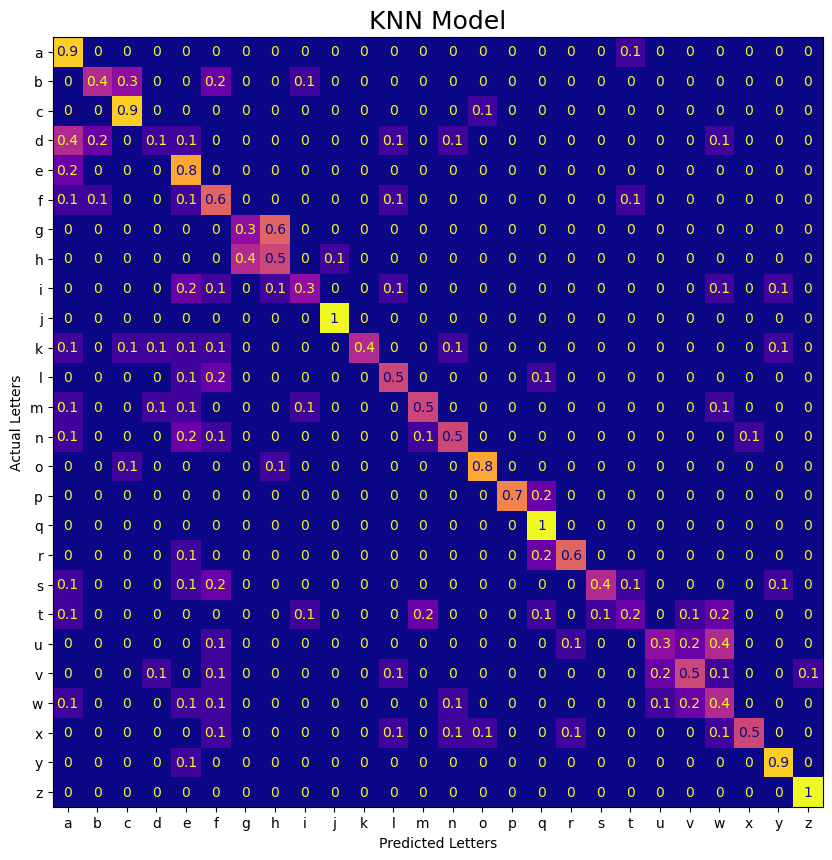

In [82]:
#Sources: https://pyts.readthedocs.io/en/stable/generated/pyts.classification.KNeighborsClassifier.html#pyts.classification.KNeighborsClassifier   |    https://pyts.readthedocs.io/en/stable/modules/multivariate.html

clf = MultivariateClassifier(KNeighborsClassifier(n_neighbors = 5, weights =  'distance', metric = 'dtw', n_jobs = -1))

start_time = time.time() #Tracking time to compute

kf = KFold(n_splits=4, shuffle = True) #Initializing k-fold
kf.get_n_splits(X)

acc_score = [] #Creating an empty list to add the accuracy to
i = 0 #Creating a counter for finding avg accuracy at each step

confusion_matrix_total = np.zeros((len(list(np.unique(target))), len(list(np.unique(target)))))

#Condicting k-fold
for train_index, test_index in kf.split(X):
    i += 1
    X_train, X_test, y_train, y_test = X[train_index,:], X[test_index,:], target[train_index] , target[test_index]

    clf.fit(X_train,y_train)

    acc = clf.score(X_test, y_test) #Getting accuracy score 
    acc_score.append(acc) #Appending accuracy score to the accuracy list
    print(f'Fold {i} Accuracy =', round(acc*100), '%')
    
    y_prediction = clf.predict(X_test) #Predicting words
    confusion_matrix_total += metrics.confusion_matrix(y_test, y_prediction, labels = list(np.unique(target))) #Confusion matrix is an average confusion matrix from all folds

end_time = time.time()
time_calc(start_time, end_time)
print("---")
print(f'Model Accuracy: {round(np.mean(acc_score)*100, 3)}%')

full_report(confusion_matrix_total, target, 'Letters', 'KNN', clf)
precision_recall(confusion_matrix_total, target, 'Letters')

### Interval

**Grid Search**

Caution: This takes a very long time to run

In [ ]:
start_time = time.time() #Tracking time to compute

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.33) #Splitting the data

params = [{'estimator__n_windows': [3, 4, 5, 6],
         'estimator__n_estimators': [450, 500, 550],}]

interval = MultivariateClassifier(TimeSeriesForest())

gs_int = GridSearchCV(interval, param_grid=params, scoring='accuracy', cv=4, verbose = 10) #4 fold
gs_int.fit(X_train, y_train) 
gs_int.best_params_

gs_int.score(X_train, y_train)

end_time = time.time()
time_calc(start_time, end_time)

Best Parameters: 

{'estimator__n_estimators': 500, 'estimator__n_windows': 4}


Fold 1 Accuracy = 52 %
Fold 2 Accuracy = 39 %
Fold 3 Accuracy = 39 %
Fold 4 Accuracy = 41 %
Time Elapsed: 2:10.189
---
Model Accuracy: 42.749%


,Precision,Recall,F-Score
Letters,,,
a,14.29,16.67,0.15
b,33.33,27.27,0.30
c,60.00,75.00,0.67
d,42.86,50.00,0.46
e,30.77,66.67,0.42
f,45.45,41.67,0.43
g,27.27,30.00,0.29
h,37.50,27.27,0.32
i,40.00,33.33,0.36


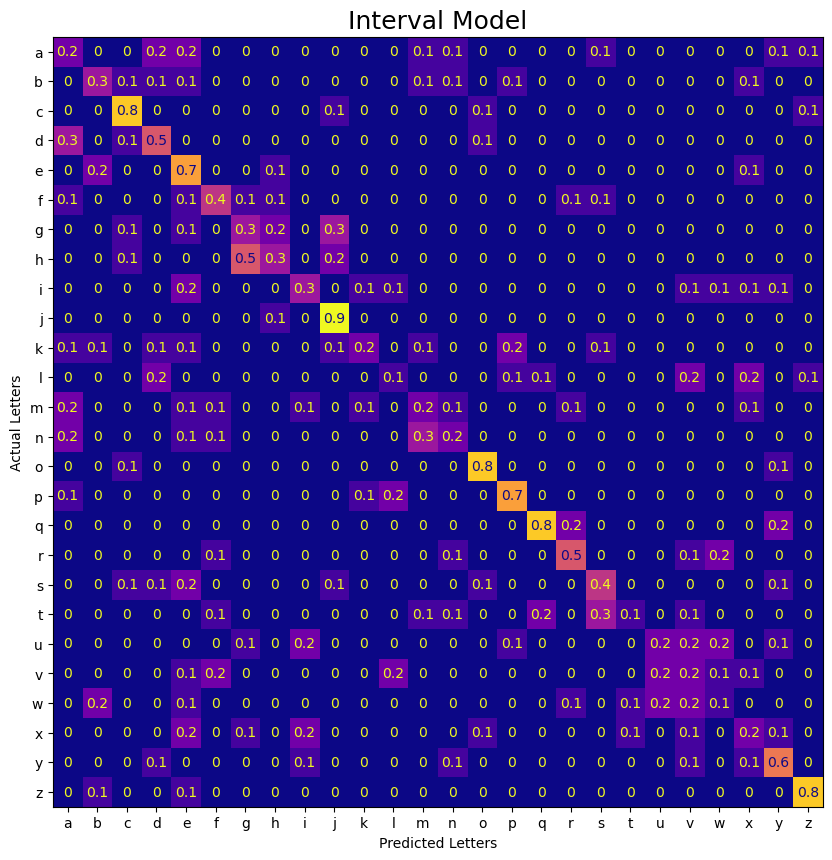

In [83]:
#Sources: https://pyts.readthedocs.io/en/latest/generated/pyts.classification.TimeSeriesForest.html   |    https://pyts.readthedocs.io/en/stable/modules/multivariate.html

clf = MultivariateClassifier(TimeSeriesForest(n_windows = 4, n_estimators = 500))

start_time = time.time() #Tracking time to compute

kf = KFold(n_splits=4, shuffle = True) #Initializing k-fold
kf.get_n_splits(X)

acc_score = [] #Creating an empty list to add the accuracy to
i = 0 #Creating a counter for finding avg accuracy at each step

confusion_matrix_total = np.zeros((len(list(np.unique(target))), len(list(np.unique(target)))))

#Condicting k-fold
for train_index, test_index in kf.split(X):
    i += 1
    X_train, X_test, y_train, y_test = X[train_index,:], X[test_index,:], target[train_index] , target[test_index]

    clf.fit(X_train,y_train)

    acc = clf.score(X_test, y_test) #Getting accuracy score 
    acc_score.append(acc) #Appending accuracy score to the accuracy list
    print(f'Fold {i} Accuracy =', round(acc*100), '%')
    
    y_prediction = clf.predict(X_test) #Predicting words
    confusion_matrix_total += metrics.confusion_matrix(y_test, y_prediction, labels = list(np.unique(target))) #Confusion matrix is an average confusion matrix from all folds

end_time = time.time()
time_calc(start_time, end_time)
print("---")
print(f'Model Accuracy: {round(np.mean(acc_score)*100, 3)}%')

full_report(confusion_matrix_total, target, 'Letters', 'Interval', clf)
precision_recall(confusion_matrix_total, target, 'Letters')

### CNN

In [255]:
#Converting alphabetical targets to numerical target 
le = preprocessing.LabelEncoder()
le.fit(target) #Fitting to the target data
new_target = le.transform(target) #Transforming

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, new_target, test_size=0.33, random_state = 12, stratify = target) #Splitting the data

Epoch 1/100
7/7 [==============================] - 1s 35ms/step - loss: 4.2135 - accuracy: 0.0469 - val_loss: 4.0900 - val_accuracy: 0.1333
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 3.9099 - accuracy: 0.2066 - val_loss: 3.9459 - val_accuracy: 0.1619
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 3.6870 - accuracy: 0.3052 - val_loss: 3.7768 - val_accuracy: 0.2000
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 3.4086 - accuracy: 0.4038 - val_loss: 3.6024 - val_accuracy: 0.2476
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 3.1180 - accuracy: 0.5023 - val_loss: 3.4197 - val_accuracy: 0.2952
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 2.8047 - accuracy: 0.5399 - val_loss: 3.2154 - val_accuracy: 0.3333
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 2.4988 - accuracy: 0.6761 - val_loss: 3.0054 - val_accuracy: 0.4000
Epoch 8/100
7/7 [===

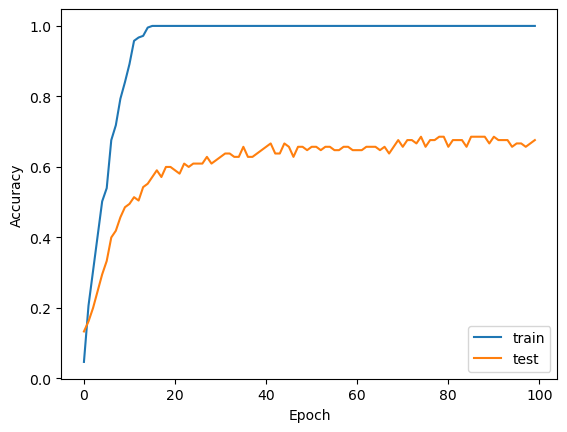

In [267]:
#Sources: https://www.tensorflow.org/tutorials/images/cnn  |   https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5   |   https://medium.com/@technopremiumusa/cnn-for-time-series-classification-with-tensorflow-13acf89c1dc6


#Creating the new model
model = models.Sequential()
#Adding layers
model.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(l=0.01))) 
model.add(layers.MaxPooling1D(pool_size = 1))
model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(layers.MaxPooling1D(pool_size = 1))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu')) #Fully connected layer
model.add(layers.Dense(len(np.unique(new_target)))) #Output layer

#Training the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

#Plotting the evolution of the training
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

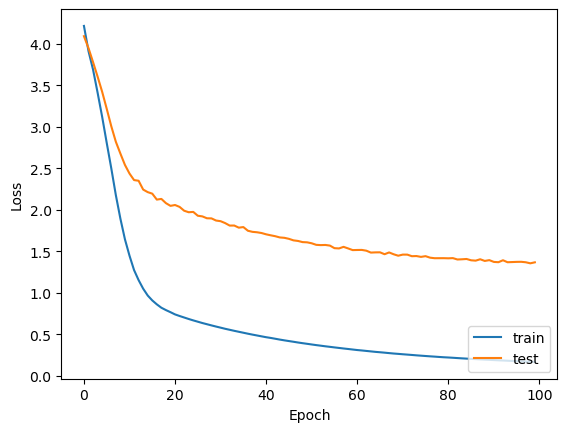

In [268]:
#Plotting the evolution of the training
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [269]:
score = model.evaluate(X_test, y_test, verbose=10)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3659799098968506
Test accuracy: 0.6761904954910278


1/1 [==============================] - 0s 20ms/step


,Precision,Recall,F-Score
Letters,,,
a,100.00,100.00,1.00
b,40.00,50.00,0.44
c,75.00,75.00,0.75
d,100.00,75.00,0.86
e,100.00,75.00,0.86
f,100.00,25.00,0.40
g,42.86,100.00,0.60
h,100.00,75.00,0.86
i,60.00,75.00,0.67


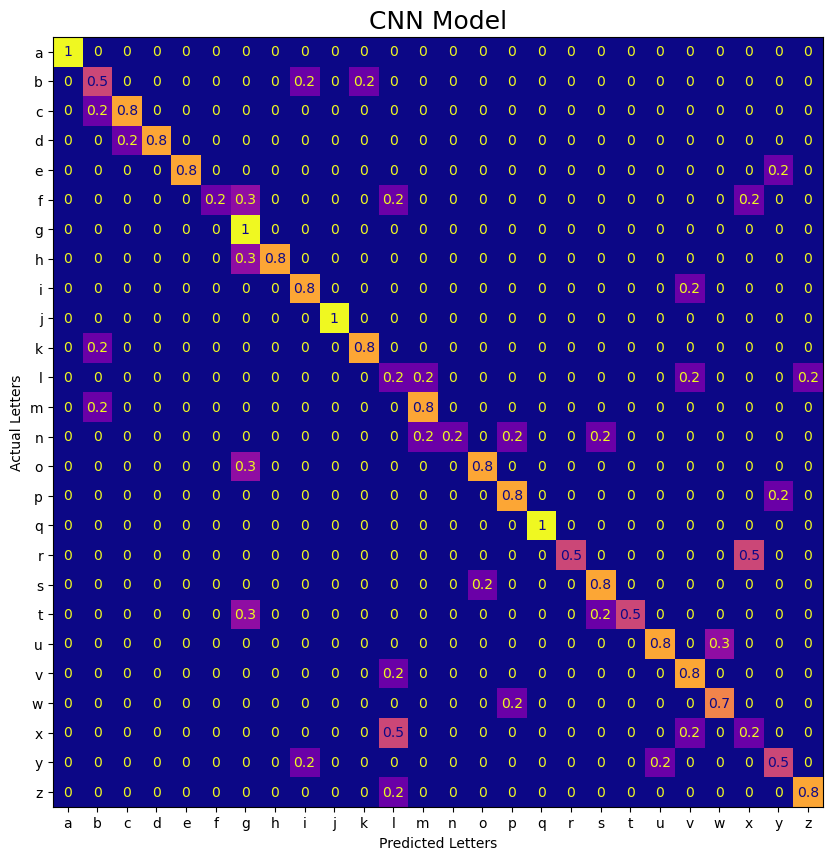

In [270]:
#Finding the predicted y values needed for confusion matrix and precision/recall
y_predicted = []
for i in range(0, len(X_test)):
    y_predicted.append(le.inverse_transform(np.argmax(model.predict(X_test[i:i+1])).reshape([1,]))[0])
    
confusion_matrix_total = metrics.confusion_matrix(le.inverse_transform(y_test), y_predicted, labels = list(np.unique(target)))
full_report(confusion_matrix_total, target, 'Letters', 'CNN', clf)
precision_recall(confusion_matrix_total, target, 'Letters')

# Trigrams

## Creating Trigrams
**Y is used for trigrams. X was previously used for individual letters.**

In [13]:
path = 'C://Users//dionn//Documents//GW//Spring 2023//Capstone//Letters'
all_files = listdir(path)

In [14]:
start_time = time.time() #Tracking time to compute
data = list() #Emtpy list to add all data to
target = np.array([]) #Creating an array to append the target letters to

for file in all_files:
    filename = path + "//" + file #Making sure each file has the full path
    df = pd.read_csv(filename) #Opening the CSV to a temporary df
    
    #Adding a check because some .csv files don't come with column labels first for some reason
    if df.columns[0] == 'loggingTime(txt)':
        df.drop(columns = ['loggingTime(txt)', 'locationTimestamp_since1970(s)',
           'locationLatitude(WGS84)', 'locationLongitude(WGS84)',
           'locationAltitude(m)', 'locationSpeed(m/s)',
           'locationSpeedAccuracy(m/s)', 'locationCourse(°)',
           'locationCourseAccuracy(°)', 'locationVerticalAccuracy(m)',
           'locationHorizontalAccuracy(m)', 'locationFloor(Z)',
           'accelerometerTimestamp_sinceReboot(s)', 'motionTimestamp_sinceReboot(s)',
           'motionAttitudeReferenceFrame(txt)', 'motionMagneticFieldX(µT)', 'motionMagneticFieldY(µT)',
           'motionMagneticFieldZ(µT)', 'motionHeading(°)','motionMagneticFieldCalibrationAccuracy(Z)',
           'activityTimestamp_sinceReboot(s)', 'activity(txt)',
           'activityActivityConfidence(Z)', 'activityActivityStartDate(txt)',
           'pedometerStartDate(txt)', 'pedometerNumberofSteps(N)',
           'pedometerAverageActivePace(s/m)', 'pedometerCurrentPace(s/m)',
           'pedometerCurrentCadence(steps/s)', 'pedometerDistance(m)',
           'pedometerFloorAscended(N)', 'pedometerFloorDescended(N)',
           'pedometerEndDate(txt)', 'altimeterTimestamp_sinceReboot(s)',
           'altimeterReset(bool)', 'altimeterRelativeAltitude(m)','altimeterPressure(kPa)', 'batteryState(N)', 
           'batteryLevel(R)', 'motionGravityY(G)', 'motionGravityZ(G)', 'motionGravityX(G)', 'motionQuaternionX(R)', 'motionQuaternionY(R)',
           'motionQuaternionZ(R)'], axis = 0, inplace = True) #Dropping columns

        features = list(df.columns) #Getting a list of features remaining for use later on

        values = df.values #Getting the values for the current dataframe in array form
        data_list = list() #Creating an empty list to append each time period to

        #Creating a list of lists where each sublist is all remaining feature values at one time
        #Done to convert to the correct nested array form for time series padding 
        #Data list is of shape (length, features)
        for i in range(len(values)):
            data_list.append(list(values[i]))

        #Normalizing the data (mean 0, sd = 1) for each feature
        scaler = StandardScaler()
        scaler.fit(data_list) #Finding what the mean and SD should be for each feature
        data_scaled = scaler.transform(data_list).tolist() #Applying the scaling transformation on the list and saving as a list to make it easier to append to full dataset
        #data_scaled = data_list
        
        #Data is of the shape (samples, length, features)
        data.append(data_scaled) #Adding the list to the main data list

        target = np.append(target, str(file[0])) #Using the first letter of the file name to note the target letter
    else:
        continue

end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')

Time Elapsed: 1.759 seconds
Time Per File: 0.005 seconds


In [15]:
#Padding the end of shorter series with 0 values
start_time = time.time() #Tracking time to compute
x = tf.keras.preprocessing.sequence.pad_sequences(data, padding = 'post', value = 0, dtype='float32')
end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')

Time Elapsed: 0.025 seconds
Time Per File: 0.0 seconds


In [16]:
#Changing the shape of the padded date to be (samples, featues, time periods) instead of (samples, time periods, features)
start_time = time.time() #Tracking time to compute

X = list() #Using list because it can append each sample separately without merging them together

for i in range(len(x)):
    X.append(x[i].T)
    
X = np.array([X][0]) #Converting list back to array, need 0 index or it adds another dimension for some reason

end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')
print('--')
print(f'Samples: {len(X)}')
print(f'Features Per Sample: {len(X[0])}')
print(f'Length of Each Sample: {len(X[0][0])} = {len(X[0][0])/20} seconds') #20 HZ sampling

Time Elapsed: 0.002 seconds
Time Per File: 0.0 seconds
--
Samples: 318
Features Per Sample: 13
Length of Each Sample: 117 = 5.85 seconds


In [17]:
def trigram(trigram):
    """
    Combined the data for three letters to create a trigram of letters. This randomly pairs the letters but keeps all n features consistent between them.
    
    Inputs:
    trigram = String of the trigram
    
    Return:
    Y_trigram = Numpy arary of shape (n_trigrams, features, data_length) that can be stacked with Y (the overall data set)
    """
    #Splitting the trigram into letters
    letters = list(trigram)
    letter1 = letters[0]
    letter2 = letters[1]
    letter3 = letters[2]
    
    
    letter1_indices = np.where(target == letter1)[0] #Gets the indices where that letter is stored in the data
    random.shuffle(letter1_indices) #Shuffles the indices in place to create a random pairing of letters
    letter2_indices = np.where(target == letter2)[0] #Gets the indices where that letter is stored in the data
    random.shuffle(letter2_indices) #Shuffles the indices in place to create a random pairing of letters
    letter3_indices = np.where(target == letter3)[0] #Gets the indices where that letter is stored in the data
    random.shuffle(letter3_indices) #Shuffles the indices in place to create a random pairing of letters
    
    Y_trigram = np.zeros((min(len(letter1_indices), len(letter2_indices), len(letter3_indices)), len(X[0]), len(X[0][0])*3)) #Creating an intermediate array that will collect all of the samples of just this trigram; shape is (n_trigrams, features, data_length)
    
    for j in range(min(len(letter1_indices), len(letter2_indices), len(letter3_indices))): #Repeating for as many times as the smallest index list
        Y_intermediate = np.zeros((len(X[0]), len(X[0][0])*3)) #Creating an intermediate array that is (13, 351) long and I will add each feature to this; shape is (features, data_length)
        for i in range(len(X[0])): #Iterating over each feature
            y = X[letter1_indices[j]][i] #Adding the feature for the first letter; y is shape (data_length)
            y = np.append(y, X[letter2_indices[j]][i]) #Appending the feature for the second letter
            y = np.append(y, X[letter3_indices[j]][i]) #Appending the feature for the third letter
            Y_intermediate[i] = y #Joining this feature with the other features
        Y_trigram[j] = Y_intermediate #Joining all of the features as one complete sample of the trigram
        
    targets = [trigram]*len(Y_trigram) #Creating a list of targets (all same trigram)
    
    return Y_trigram, targets

In [18]:
trigrams = ['the', 'and', 'tha', 'ent', 'ing', 'ion', 'tio', 'for', 'nde', 'has', 'nce', 'edt', 'tis', 'oft', 'sth', 'men', 'ish', 'any']

In [19]:
Y = np.empty((0, len(X[0]), len(X[0][0])*3)) #Creating an empty array that I will add all trigram samples to; shape is (total_trigram_samples, features, data_length)
trigram_targets = []


for tri in trigrams:
    temp_trigram, temp_targets = trigram(tri) #Getting the results from the function
    Y = np.vstack((Y, temp_trigram))
    trigram_targets.extend(temp_targets) #Adding the targets for this trigram to the overall list of targets
    
trigram_targets = np.array(trigram_targets) #Converting targets to an array for training

## Trigram Models

### KNN

**Grid Search**

Caution: This takes a very long time to run

In [ ]:
start_time = time.time() #Tracking time to compute

X_train, X_test, y_train, y_test = train_test_split(Y, trigram_targets, test_size=0.33) #Splitting the data

params = [{'estimator__n_neighbors': [5, 7, 9],
         'estimator__weights': ['uniform', 'distance'],
         'estimator__metric': ['minkowski', 'dtw']}]

knn = MultivariateClassifier(KNeighborsClassifier())

gs_knn = GridSearchCV(knn, param_grid=params, scoring='accuracy', cv=3, verbose = 10) #4 fold
gs_knn.fit(Y, trigram_targets) 
gs_knn.best_params_

end_time = time.time()
time_calc(start_time, end_time)

Best Parameters:

{'estimator__metric': 'dtw',
 'estimator__n_neighbors': 7,
 'estimator__weights': 'uniform'}


Fold 1 Accuracy = 56 %
Fold 2 Accuracy = 62 %
Fold 3 Accuracy = 65 %
Fold 4 Accuracy = 69 %
Time Elapsed: 19:39.129
---
Model Accuracy: 62.981%


,Precision,Recall,F-Score
Trigrams,,,
and,27.78,41.67,0.33
any,12.50,8.33,0.10
edt,31.58,50.00,0.39
ent,25.00,16.67,0.20
for,80.00,100.00,0.89
has,100.00,100.00,1.00
ing,100.00,60.00,0.75
ion,80.00,66.67,0.73
ish,76.92,90.91,0.83


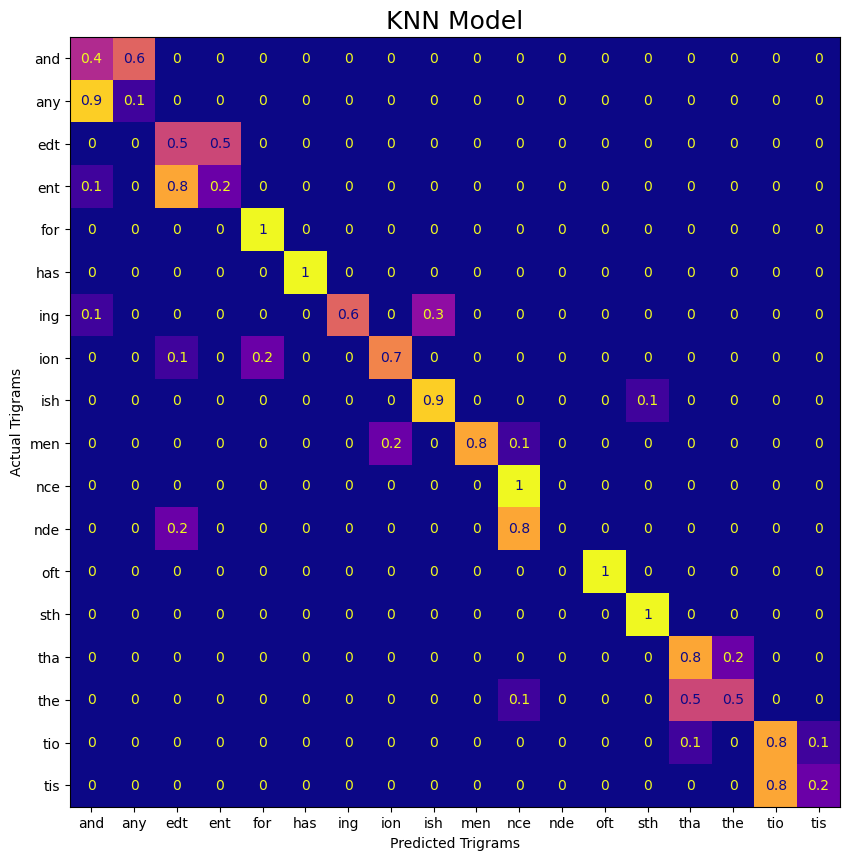

In [89]:
#Sources: https://pyts.readthedocs.io/en/stable/generated/pyts.classification.KNeighborsClassifier.html#pyts.classification.KNeighborsClassifier   |    https://pyts.readthedocs.io/en/stable/modules/multivariate.html

clf = MultivariateClassifier(KNeighborsClassifier(n_neighbors = 7, weights =  'uniform', metric = 'dtw', n_jobs = -1))

start_time = time.time() #Tracking time to compute

kf = KFold(n_splits=4, shuffle = True) #Initializing k-fold
kf.get_n_splits(Y)

acc_score = [] #Creating an empty list to add the accuracy to
i = 0 #Creating a counter for finding avg accuracy at each step

confusion_matrix_total = np.zeros((len(list(np.unique(trigram_targets))), len(list(np.unique(trigram_targets)))))

#Condicting k-fold
for train_index, test_index in kf.split(Y):
    i += 1
    X_train, X_test, y_train, y_test = Y[train_index,:], Y[test_index,:], trigram_targets[train_index] , trigram_targets[test_index]

    clf.fit(X_train,y_train)

    acc = clf.score(X_test, y_test) #Getting accuracy score 
    acc_score.append(acc) #Appending accuracy score to the accuracy list
    print(f'Fold {i} Accuracy =', round(acc*100), '%')
    
    y_prediction = clf.predict(X_test) #Predicting words
    confusion_matrix_total += metrics.confusion_matrix(y_test, y_prediction, labels = list(np.unique(trigram_targets))) #Confusion matrix is an average confusion matrix from all folds

end_time = time.time()
time_calc(start_time, end_time)
print("---")
print(f'Model Accuracy: {round(np.mean(acc_score)*100, 3)}%')

full_report(confusion_matrix_total, trigram_targets, 'Trigrams', 'KNN', clf)
precision_recall(confusion_matrix_total, trigram_targets, 'Trigrams')

### Interval

**Grid Search**

Caution: This takes a very long time to run

In [ ]:
start_time = time.time() #Tracking time to compute


params = [{'estimator__n_windows': [3, 4, 5, 6],
         'estimator__n_estimators': [450, 500, 550],}]

interval = MultivariateClassifier(TimeSeriesForest())

gs_int = GridSearchCV(interval, param_grid=params, scoring='accuracy', cv=3, verbose = 10) #3 fold
gs_int.fit(Y, trigram_targets) 
gs_int.best_params_

end_time = time.time()
time_calc(start_time, end_time)

Best Parameters:

{'estimator__n_estimators': 550, 'estimator__n_windows': 4}

Fold 1 Accuracy = 38 %
Fold 2 Accuracy = 29 %
Fold 3 Accuracy = 31 %
Fold 4 Accuracy = 37 %
Time Elapsed: 54.881 seconds
---
Model Accuracy: 33.654%


,Precision,Recall,F-Score
Trigrams,,,
and,25.00,33.33,0.29
any,40.00,50.00,0.44
edt,20.00,25.00,0.22
ent,0.00,0.00,0.00
for,41.18,58.33,0.48
has,75.00,54.55,0.63
ing,25.00,20.00,0.22
ion,27.27,25.00,0.26
ish,33.33,36.36,0.35


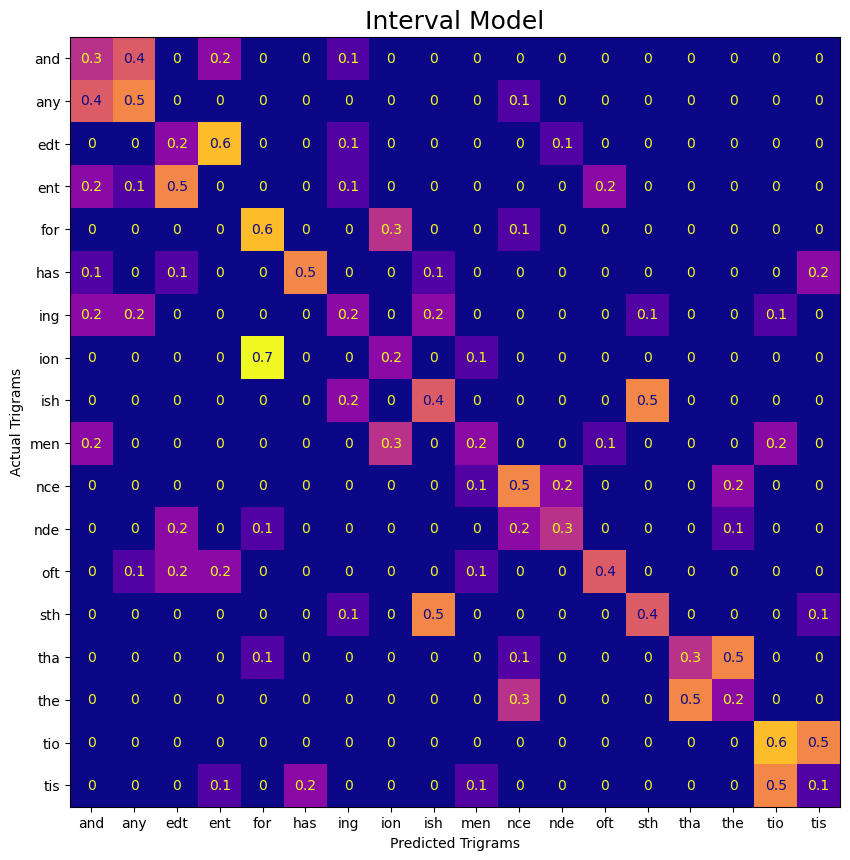

In [271]:
#Sources: https://pyts.readthedocs.io/en/latest/generated/pyts.classification.TimeSeriesForest.html   |    https://pyts.readthedocs.io/en/stable/modules/multivariate.html

clf = MultivariateClassifier(TimeSeriesForest(n_windows = 4, n_estimators = 550))

start_time = time.time() #Tracking time to compute

kf = KFold(n_splits=4, shuffle = True) #Initializing k-fold
kf.get_n_splits(Y)

acc_score = [] #Creating an empty list to add the accuracy to
i = 0 #Creating a counter for finding avg accuracy at each step

confusion_matrix_total = np.zeros((len(list(np.unique(trigram_targets))), len(list(np.unique(trigram_targets)))))

#Condicting k-fold
for train_index, test_index in kf.split(Y):
    i += 1
    X_train, X_test, y_train, y_test = Y[train_index,:], Y[test_index,:], trigram_targets[train_index] , trigram_targets[test_index]

    clf.fit(X_train,y_train)

    acc = clf.score(X_test, y_test) #Getting accuracy score 
    acc_score.append(acc) #Appending accuracy score to the accuracy list
    print(f'Fold {i} Accuracy =', round(acc*100), '%')

    y_prediction = clf.predict(X_test) #Predicting words
    confusion_matrix_total += metrics.confusion_matrix(y_test, y_prediction, labels = list(np.unique(trigram_targets))) #Confusion matrix is an average confusion matrix from all folds

end_time = time.time()
time_calc(start_time, end_time)
print("---")
print(f'Model Accuracy: {round(np.mean(acc_score)*100, 3)}%')

full_report(confusion_matrix_total, trigram_targets, 'Trigrams', 'Interval', clf)
precision_recall(confusion_matrix_total, trigram_targets, 'Trigrams')

### CNN

In [273]:
#Converting alphabetical targets to numerical target 
le = preprocessing.LabelEncoder()
le.fit(trigram_targets) #Fitting to the target data
new_trigram_targets = le.transform(trigram_targets) #Transforming

In [274]:
X_train, X_test, y_train, y_test = train_test_split(Y, new_trigram_targets, test_size=0.33, random_state = 12, stratify = trigram_targets) #Splitting the data

Epoch 1/100
5/5 [==============================] - 1s 52ms/step - loss: 3.9318 - accuracy: 0.0432 - val_loss: 3.8232 - val_accuracy: 0.0435
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 3.6587 - accuracy: 0.1799 - val_loss: 3.7194 - val_accuracy: 0.1594
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 3.4410 - accuracy: 0.3309 - val_loss: 3.5932 - val_accuracy: 0.2319
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 3.2224 - accuracy: 0.4748 - val_loss: 3.4706 - val_accuracy: 0.2319
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 2.9920 - accuracy: 0.5468 - val_loss: 3.3525 - val_accuracy: 0.2464
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 2.7533 - accuracy: 0.6043 - val_loss: 3.2137 - val_accuracy: 0.3188
Epoch 7/100
5/5 [==============================] - 0s 15ms/step - loss: 2.5156 - accuracy: 0.6403 - val_loss: 3.0507 - val_accuracy: 0.3768
Epoch 8/100
5/5 [===

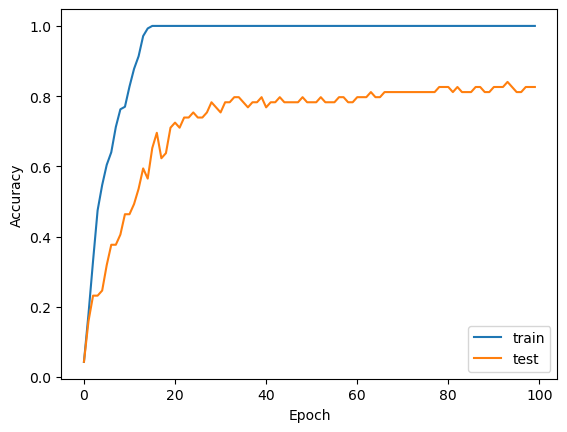

In [276]:
#Sources: https://www.tensorflow.org/tutorials/images/cnn  |   https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5   |   https://medium.com/@technopremiumusa/cnn-for-time-series-classification-with-tensorflow-13acf89c1dc6

#Creating the new model
model = models.Sequential()
#Adding layers
model.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(l=0.01))) 
model.add(layers.MaxPooling1D(pool_size = 1))
model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(layers.MaxPooling1D(pool_size = 1))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu')) #Fully connected layer
model.add(layers.Dense(len(np.unique(trigram_targets)))) #Output layer

#Training the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

#Plotting the evolution of the training
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

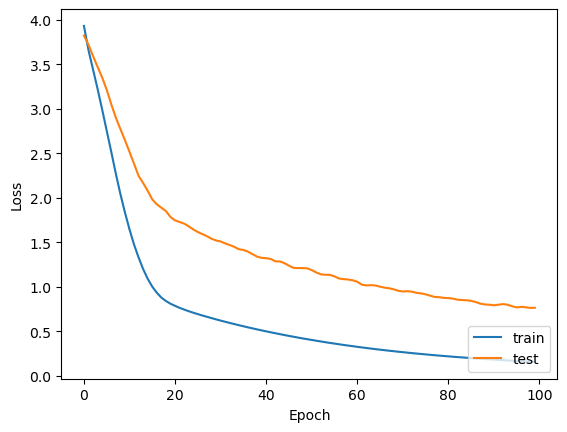

In [277]:
#Plotting the evolution of the training
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [278]:
score = model.evaluate(X_test, y_test, verbose=10)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7636200785636902
Test accuracy: 0.8260869383811951


1/1 [==============================] - 0s 23ms/step


,Precision,Recall,F-Score
Trigrams,,,
and,80.00,100.00,0.89
any,80.00,100.00,0.89
edt,100.00,50.00,0.67
ent,66.67,100.00,0.80
for,100.00,75.00,0.86
has,75.00,100.00,0.86
ing,100.00,66.67,0.80
ion,80.00,100.00,0.89
ish,100.00,100.00,1.00


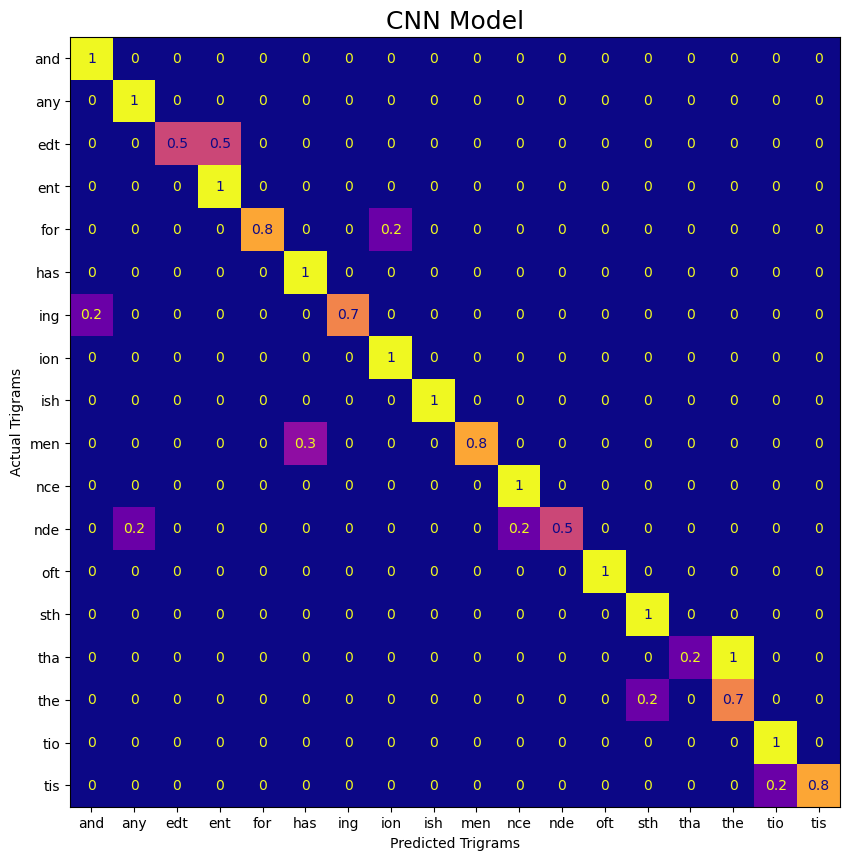

In [279]:
#Finding the predicted y values needed for confusion matrix and precision/recall
y_predicted = []
for i in range(0, len(X_test)):
    y_predicted.append(le.inverse_transform(np.argmax(model.predict(X_test[i:i+1])).reshape([1,]))[0])
    
confusion_matrix_total = metrics.confusion_matrix(le.inverse_transform(y_test), y_predicted, labels = list(np.unique(trigram_targets)))
full_report(confusion_matrix_total, trigram_targets, 'Trigrams', 'CNN', clf)
precision_recall(confusion_matrix_total, trigram_targets, 'Trigrams')

# Words

## Opening Words
**W is used for words. X was previously used for individual letters and Y was used for trigrams.**

In [20]:
word_path = 'C://Users//dionn//Documents//GW//Spring 2023//Capstone//Words'
all_files_words = listdir(word_path)

In [21]:
start_time = time.time() #Tracking time to compute
data_w = list() #Emtpy list to add all words to
target_w = np.array([]) #Creating an array to append the target letters to

for file in all_files_words:
    filename = word_path + "//" + file #Making sure each file has the full path
    df = pd.read_csv(filename) #Opening the CSV to a temporary df
    
    #Adding a check because some .csv files don't come with column labels first for some reason
    try:
        if df.columns[0] == 'loggingTime(txt)':
            if type(df['accelerometerAccelerationX(G)'][0]) == str:
                #This finds if there is a random row with string data in it
                #Then it only grabs the data after that row - it seems like the first data was a duplicate of the rest of the data anyway
                df = df.iloc[(df.loc[df['accelerometerAccelerationX(G)'] == 'accelerometerAccelerationX(G)'].index[0]+1):].reset_index().drop(['index'], axis = 1)
                
            df.drop(columns = ['loggingTime(txt)', 'locationTimestamp_since1970(s)',
               'locationLatitude(WGS84)', 'locationLongitude(WGS84)',
               'locationAltitude(m)', 'locationSpeed(m/s)',
               'locationSpeedAccuracy(m/s)', 'locationCourse(°)',
               'locationCourseAccuracy(°)', 'locationVerticalAccuracy(m)',
               'locationHorizontalAccuracy(m)', 'locationFloor(Z)',
               'accelerometerTimestamp_sinceReboot(s)', 'motionTimestamp_sinceReboot(s)',
               'motionAttitudeReferenceFrame(txt)', 'motionMagneticFieldX(µT)', 'motionMagneticFieldY(µT)',
               'motionMagneticFieldZ(µT)', 'motionHeading(°)','motionMagneticFieldCalibrationAccuracy(Z)',
               'activityTimestamp_sinceReboot(s)', 'activity(txt)',
               'activityActivityConfidence(Z)', 'activityActivityStartDate(txt)',
               'pedometerStartDate(txt)', 'pedometerNumberofSteps(N)',
               'pedometerAverageActivePace(s/m)', 'pedometerCurrentPace(s/m)',
               'pedometerCurrentCadence(steps/s)', 'pedometerDistance(m)',
               'pedometerFloorAscended(N)', 'pedometerFloorDescended(N)',
               'pedometerEndDate(txt)', 'altimeterTimestamp_sinceReboot(s)',
               'altimeterReset(bool)', 'altimeterRelativeAltitude(m)','altimeterPressure(kPa)', 'batteryState(N)', 
               'batteryLevel(R)', 'motionGravityY(G)', 'motionGravityZ(G)', 'motionGravityX(G)', 'motionQuaternionX(R)', 'motionQuaternionY(R)',
               'motionQuaternionZ(R)'], axis = 0, inplace = True) #Dropping columns

            features_w = list(df.columns) #Getting a list of features remaining for use later on

            values = df.values #Getting the values for the current dataframe in array form
            data_list = list() #Creating an empty list to append each time period to

            #Creating a list of lists where each sublist is all remaining feature values at one time
            #Done to convert to the correct nested array form for time series padding 
            #Data list is of shape (length, features)
            for i in range(len(values)):
                data_list.append(list(values[i]))

            #Normalizing the data (mean 0, sd = 1) for each feature
            scaler = StandardScaler()
            scaler.fit(data_list) #Finding what the mean and SD should be for each feature
            data_scaled = scaler.transform(data_list).tolist() #Applying the scaling transformation on the list and saving as a list to make it easier to append to full dataset

            #Data is of the shape (samples, length, features)
            data_w.append(data_scaled) #Adding the list to the main data list

            target_w = np.append(target_w, str(file[:file.find('_')])) #Using the first letter of the file name to note the target letter
        else:
            print(file)
            continue
    except:
        print(file)

end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files_words)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')

Time Elapsed: 5.198 seconds
Time Per File: 0.02 seconds


### Padding Time Series

In [22]:
#Sources: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

#Padding the end of shorter series with 0 values
start_time = time.time() #Tracking time to compute
w = tf.keras.preprocessing.sequence.pad_sequences(data_w, padding = 'post', value = 0, dtype='float32')
end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files_words)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')

Time Elapsed: 0.028 seconds
Time Per File: 0.0 seconds


### Chaning Data Shape

In [23]:
#Changing the shape of the padded date to be (samples, featues, time periods) instead of (samples, time periods, features)
start_time = time.time() #Tracking time to compute

W = list() #Using list because it can append each sample separately without merging them together

for i in range(len(w)):
    W.append(w[i].T)
    
W = np.array([W][0]) #Converting list back to array, need 0 index or it adds another dimension for some reason

end_time = time.time()
time_elapsed = end_time - start_time
time_per_file = time_elapsed/len(all_files_words)
print(f'Time Elapsed: {round(time_elapsed, 3)} seconds')
print(f'Time Per File: {round(time_per_file, 3)} seconds')
print('--')
print(f'Samples: {len(W)}')
print(f'Features Per Sample: {len(W[0])}')
print(f'Length of Each Sample: {len(W[0][0])} = {len(W[0][0])/20} seconds') #20 HZ sampling

Time Elapsed: 0.002 seconds
Time Per File: 0.0 seconds
--
Samples: 261
Features Per Sample: 13
Length of Each Sample: 144 = 7.2 seconds


## Word Models

### KNN

Fold 1 Accuracy = 98 %
Fold 2 Accuracy = 100 %
Fold 3 Accuracy = 99 %
Time Elapsed: 6:38.336
---
Model Accuracy: 98.851%


,Precision,Recall,F-Score
Words,,,
bathroom,100.00,100.0,1.00
city,90.91,100.0,0.95
deaf,100.00,100.0,1.00
food,100.00,100.0,1.00
good,100.00,95.0,0.97
hello,100.00,100.0,1.00
help,100.00,100.0,1.00
hungry,100.00,100.0,1.00
name,100.00,100.0,1.00


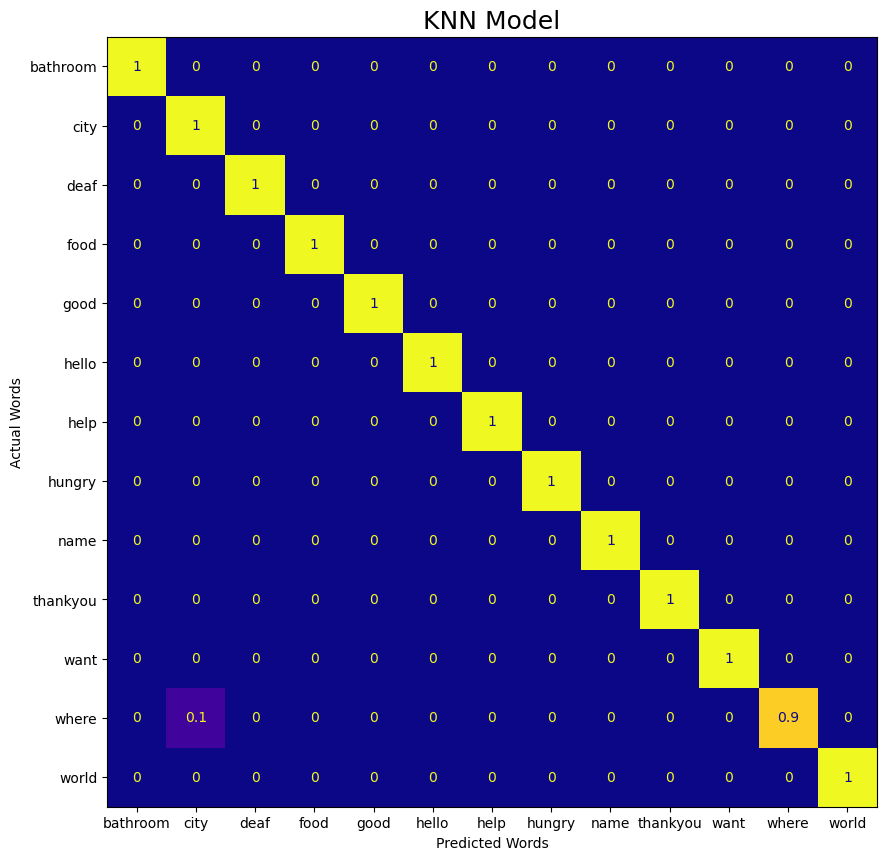

In [92]:
#Sources: https://pyts.readthedocs.io/en/stable/generated/pyts.classification.KNeighborsClassifier.html#pyts.classification.KNeighborsClassifier   |    https://pyts.readthedocs.io/en/stable/modules/multivariate.html

clf = MultivariateClassifier(KNeighborsClassifier(n_neighbors = 7, weights =  'uniform', metric = 'dtw', n_jobs = -1))

start_time = time.time() #Tracking time to compute

kf = KFold(n_splits=3, shuffle = True) #Initializing k-fold
kf.get_n_splits(W)

acc_score = [] #Creating an empty list to add the accuracy to
i = 0 #Creating a counter for finding avg accuracy at each step

confusion_matrix_total = np.zeros((len(list(np.unique(target_w))), len(list(np.unique(target_w)))))

#Condicting k-fold
for train_index, test_index in kf.split(W):
    i += 1
    X_train, X_test, y_train, y_test = W[train_index,:], W[test_index,:], target_w[train_index] , target_w[test_index]

    clf.fit(X_train,y_train)

    acc = clf.score(X_test, y_test) #Getting accuracy score 
    acc_score.append(acc) #Appending accuracy score to the accuracy list
    print(f'Fold {i} Accuracy =', round(acc*100), '%')
    
    y_prediction = clf.predict(X_test) #Predicting words
    confusion_matrix_total += metrics.confusion_matrix(y_test, y_prediction, labels = list(np.unique(target_w))) #Confusion matrix is an average confusion matrix from all folds

end_time = time.time()
time_calc(start_time, end_time)
print("---")
print(f'Model Accuracy: {round(np.mean(acc_score)*100, 3)}%')

full_report(confusion_matrix_total, target_w, 'Words', 'KNN', clf)
precision_recall(confusion_matrix_total, target_w, 'Words')

### Interval

Fold 1 Accuracy = 80 %
Fold 2 Accuracy = 91 %
Fold 3 Accuracy = 84 %
Time Elapsed: 52.474 seconds
---
Model Accuracy: 85.057%


,Precision,Recall,F-Score
Words,,,
bathroom,94.74,90.00,0.92
city,95.24,100.00,0.98
deaf,90.91,100.00,0.95
food,80.00,80.00,0.80
good,70.59,60.00,0.65
hello,78.95,75.00,0.77
help,85.71,90.00,0.88
hungry,90.48,95.00,0.93
name,90.00,90.00,0.90


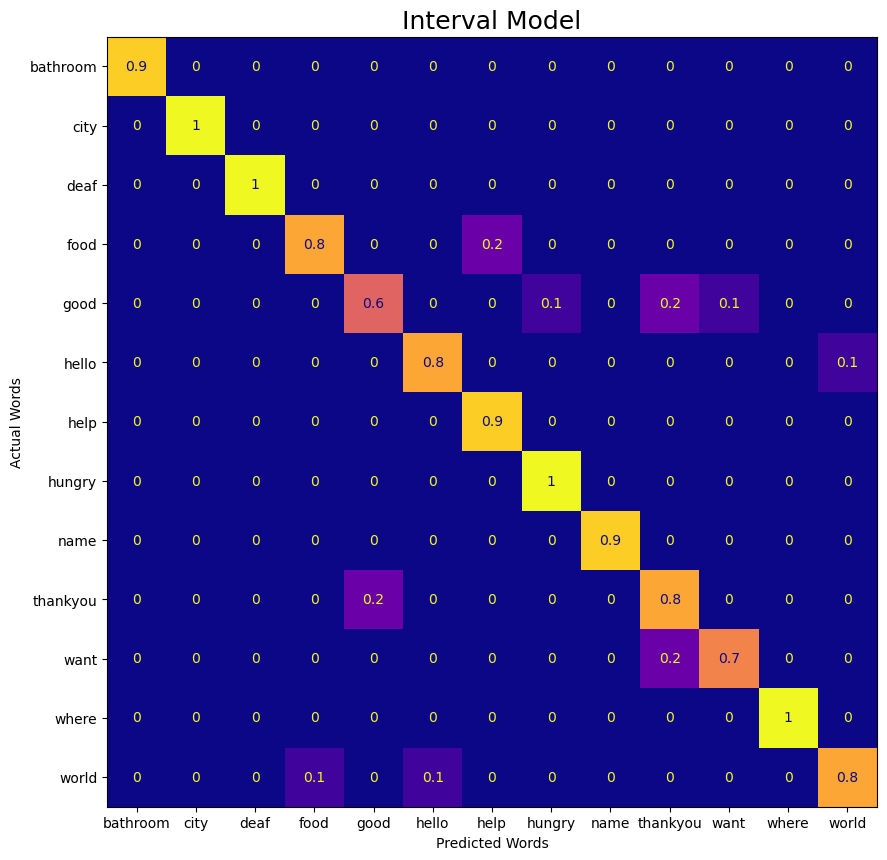

In [13]:
#Sources: https://pyts.readthedocs.io/en/latest/generated/pyts.classification.TimeSeriesForest.html   |    https://pyts.readthedocs.io/en/stable/modules/multivariate.html

clf = MultivariateClassifier(TimeSeriesForest(n_windows = 4, n_estimators = 550))

start_time = time.time() #Tracking time to compute

kf = KFold(n_splits=3, shuffle = True) #Initializing k-fold
kf.get_n_splits(W)

acc_score = [] #Creating an empty list to add the accuracy to
i = 0 #Creating a counter for finding avg accuracy at each step

confusion_matrix_total = np.zeros((len(list(np.unique(target_w))), len(list(np.unique(target_w)))))

#Condicting k-fold
for train_index, test_index in kf.split(W):
    i += 1
    X_train, X_test, y_train, y_test = W[train_index,:], W[test_index,:], target_w[train_index] , target_w[test_index]

    clf.fit(X_train,y_train)

    acc = clf.score(X_test, y_test) #Getting accuracy score 
    acc_score.append(acc) #Appending accuracy score to the accuracy list
    print(f'Fold {i} Accuracy =', round(acc*100), '%')
    
    y_prediction = clf.predict(X_test) #Predicting words
    confusion_matrix_total += metrics.confusion_matrix(y_test, y_prediction, labels = list(np.unique(target_w))) #Confusion matrix is an average confusion matrix from all folds

end_time = time.time()
time_calc(start_time, end_time)
print("---")
print(f'Model Accuracy: {round(np.mean(acc_score)*100, 3)}%')

full_report(confusion_matrix_total, target_w, 'Words', 'Interval', clf)
precision_recall(confusion_matrix_total, target_w, 'Words')

### CNN

In [242]:
#Converting alphabetical targets to numerical target 
le = preprocessing.LabelEncoder()
le.fit(target_w) #Fitting to the target data
new_target_w = le.transform(target_w) #Transforming

In [243]:
X_train, X_test, y_train, y_test = train_test_split(W, new_target_w, test_size=0.33, random_state = 12, stratify = target_w) #Splitting the data

Epoch 1/75
6/6 [==============================] - 1s 38ms/step - loss: 3.4163 - accuracy: 0.1264 - val_loss: 3.2472 - val_accuracy: 0.1264
Epoch 2/75
6/6 [==============================] - 0s 12ms/step - loss: 3.0523 - accuracy: 0.2931 - val_loss: 2.9438 - val_accuracy: 0.3908
Epoch 3/75
6/6 [==============================] - 0s 11ms/step - loss: 2.7587 - accuracy: 0.4655 - val_loss: 2.6475 - val_accuracy: 0.4943
Epoch 4/75
6/6 [==============================] - 0s 10ms/step - loss: 2.4876 - accuracy: 0.5287 - val_loss: 2.3777 - val_accuracy: 0.5862
Epoch 5/75
6/6 [==============================] - 0s 11ms/step - loss: 2.2324 - accuracy: 0.6322 - val_loss: 2.1161 - val_accuracy: 0.7241
Epoch 6/75
6/6 [==============================] - 0s 11ms/step - loss: 1.9760 - accuracy: 0.7586 - val_loss: 1.8824 - val_accuracy: 0.8046
Epoch 7/75
6/6 [==============================] - 0s 12ms/step - loss: 1.7500 - accuracy: 0.8103 - val_loss: 1.6688 - val_accuracy: 0.8276
Epoch 8/75
6/6 [===========

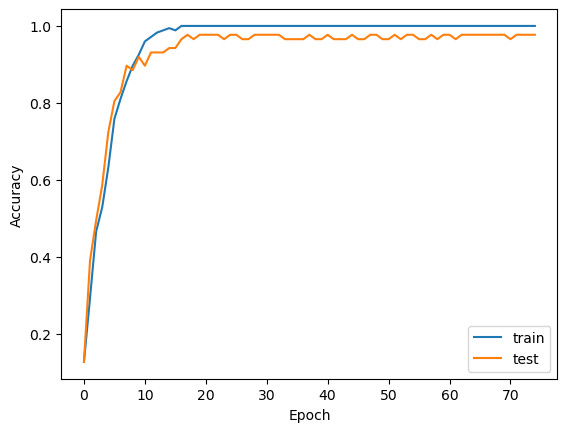

In [244]:
#Sources: https://www.tensorflow.org/tutorials/images/cnn  |   https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5   |   https://medium.com/@technopremiumusa/cnn-for-time-series-classification-with-tensorflow-13acf89c1dc6

#Creating the new model
model = models.Sequential()
#Adding layers
model.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(l=0.01))) 
model.add(layers.MaxPooling1D(pool_size = 1))
model.add(layers.Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(layers.MaxPooling1D(pool_size = 1))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu')) #Fully connected layer
model.add(layers.Dense(len(np.unique(target_w)))) #Output layer

#Training the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=75, validation_data=(X_test, y_test))

#Plotting the evolution of the training
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

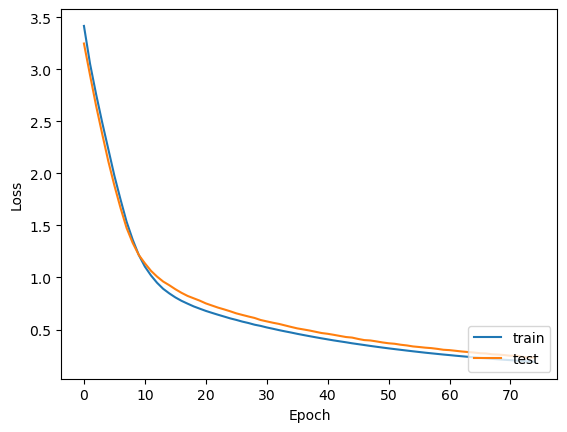

In [245]:
#Plotting the evolution of the training
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [246]:
score = model.evaluate(X_test, y_test, verbose=10)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23149853944778442
Test accuracy: 0.977011501789093


1/1 [==============================] - 0s 22ms/step


,Precision,Recall,F-Score
Words,,,
bathroom,100.0,100.00,1.00
city,100.0,100.00,1.00
deaf,100.0,100.00,1.00
food,87.5,100.00,0.93
good,87.5,100.00,0.93
hello,100.0,100.00,1.00
help,100.0,85.71,0.92
hungry,100.0,100.00,1.00
name,100.0,100.00,1.00


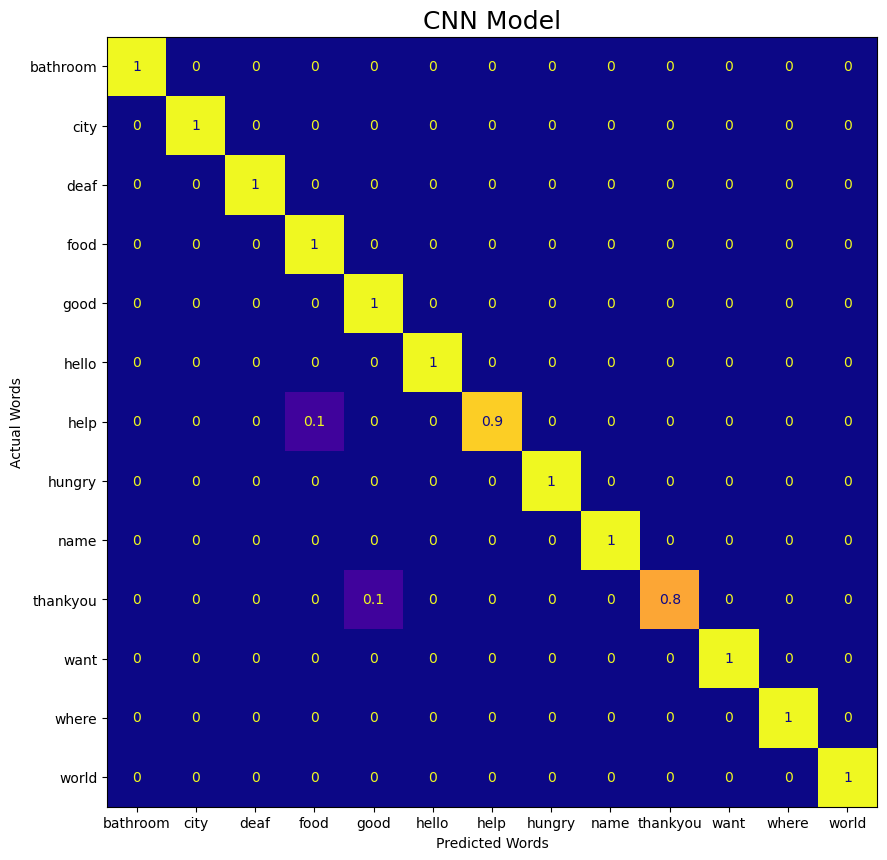

In [247]:
#Finding the predicted y values needed for confusion matrix and precision/recall
y_predicted = []
for i in range(0, len(X_test)):
    y_predicted.append(le.inverse_transform(np.argmax(model.predict(X_test[i:i+1])).reshape([1,]))[0])
    
confusion_matrix_total = metrics.confusion_matrix(le.inverse_transform(y_test), y_predicted, labels = list(np.unique(target_w)))
full_report(confusion_matrix_total, target_w, 'Words', 'CNN', clf)
precision_recall(confusion_matrix_total, target_w, 'Words')

# Plotting

## Letters

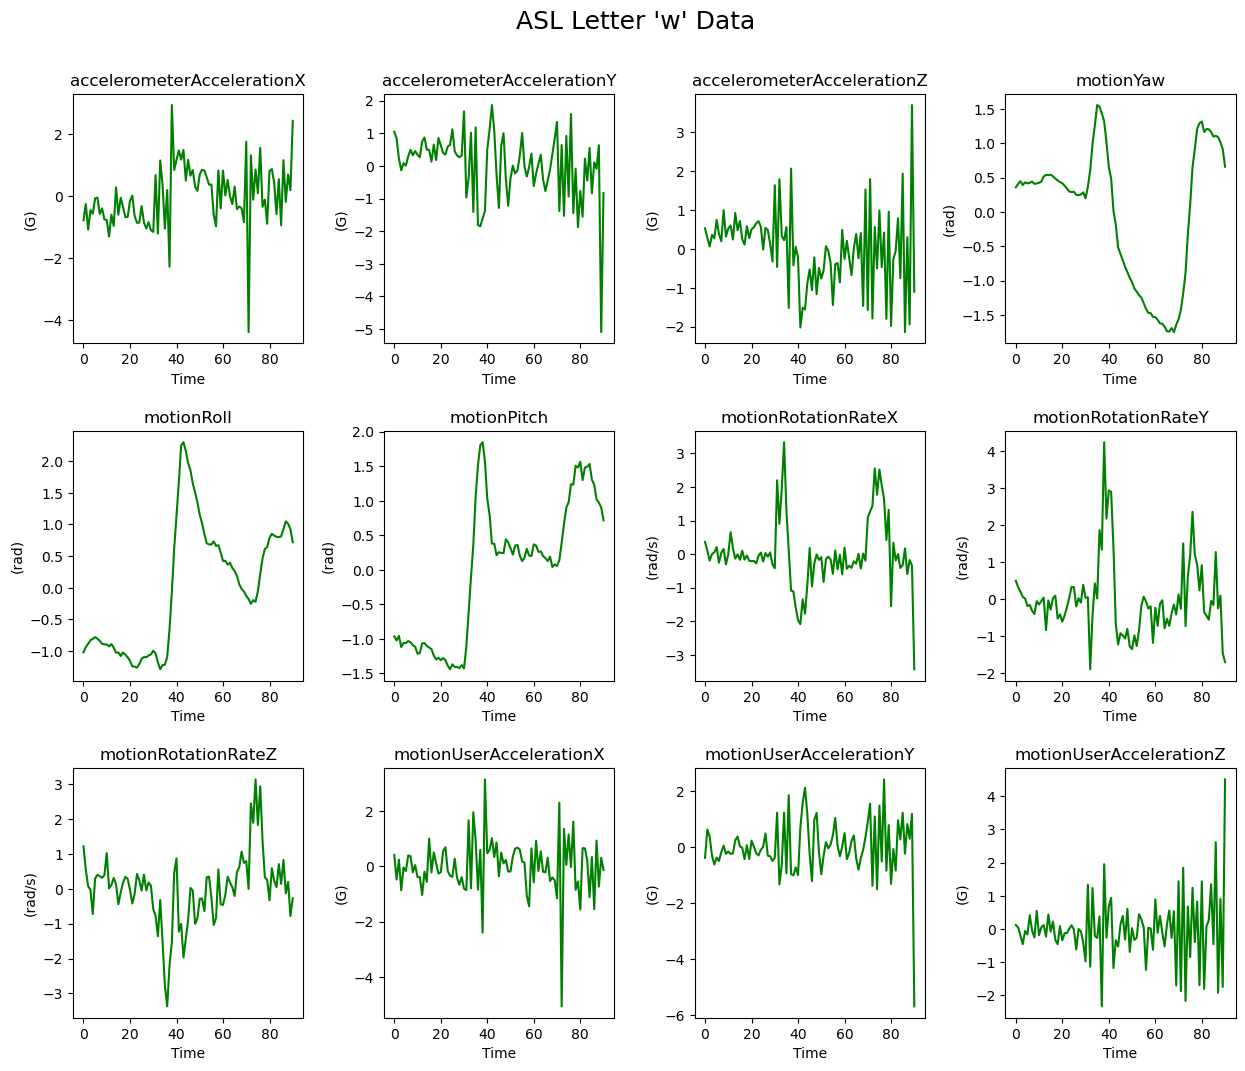

In [24]:
z = np.array(data[0]).T

#Getting dataframe to plot
df = pd.DataFrame(z.T)
df.columns = features


#Splitting into units and feature name
units = []
names = []
for i in features:
    units.append(i[i.find("("):])
    names.append(i[:i.find("(")])
    

#Plotting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.35, wspace = 0.35)
fig.suptitle("ASL Letter 'w' Data", fontsize=18, y=0.95)

# loop through tickers and axes
for feature, name, unit, ax in zip(features, names, units, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df[feature].plot(ax=ax, color = 'green')

    # chart formatting
    ax.set_title(name)
    #ax.get_legend().remove()
    ax.set_ylabel(unit)
    ax.set_xlabel('Time')

plt.show()

### Comparison Plot

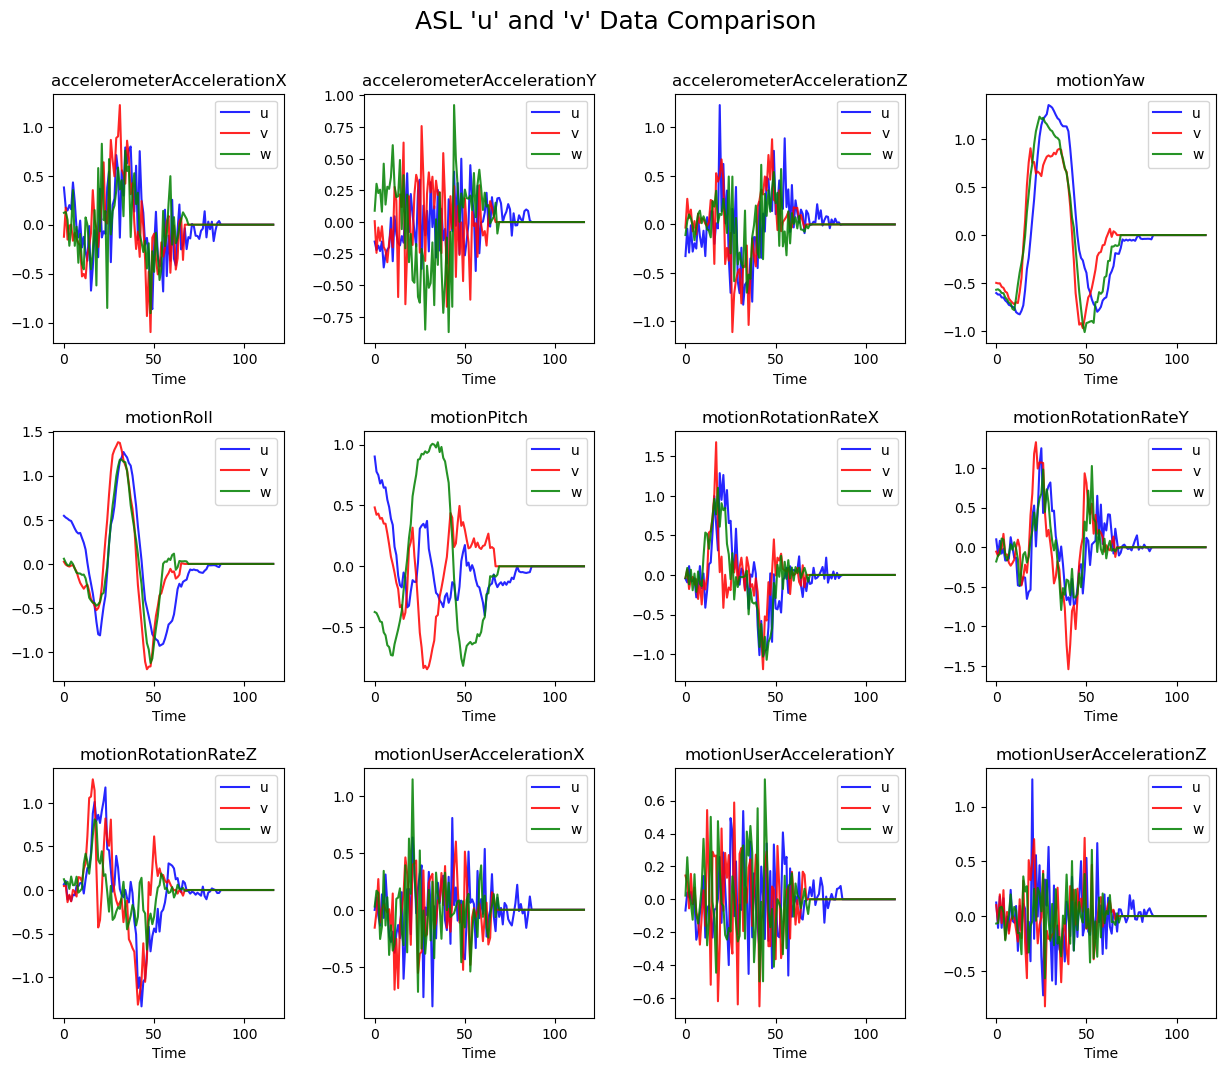

In [25]:
#Splitting into units and feature name
units = []
names = []
for i in features:
    units.append(i[i.find("("):])
    names.append(i[:i.find("(")])
    

#Plotting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.35, wspace = 0.35)
fig.suptitle("ASL 'u' and 'v' Data Comparison", fontsize=18, y=0.95)

# loop through tickers and axes
for feature, name, unit, ax in zip(features, names, units, axs.ravel()):


    data1 = 0
    word1 = "u"
    for i in list(np.where(target == word1)[0]):
        data1 += np.array(X[i][np.where(np.array(features) == feature)[0][0]])

    ax.plot(data1/len(list(np.where(target == word1)[0])), color = 'b', alpha = 0.85, label = word1)


    data2 = 0
    word2 = "v"
    for i in list(np.where(target == word2)[0]):
        data2 += np.array(X[i][np.where(np.array(features) == feature)[0][0]])

    ax.plot(data2/len(list(np.where(target == word2)[0])), color = 'r', alpha = 0.85, label = word2)
    
    data3 = 0
    word3 = "w"
    for i in list(np.where(target == word3)[0]):
        data3 += np.array(X[i][np.where(np.array(features) == feature)[0][0]])

    ax.plot(data3/len(list(np.where(target == word3)[0])), color = 'g', alpha = 0.85, label = word3)
    
    ax.set_title(name)
    #ax.set_ylabel(unit)
    ax.set_xlabel('Time')
    ax.legend()

plt.show()

## Trigrams

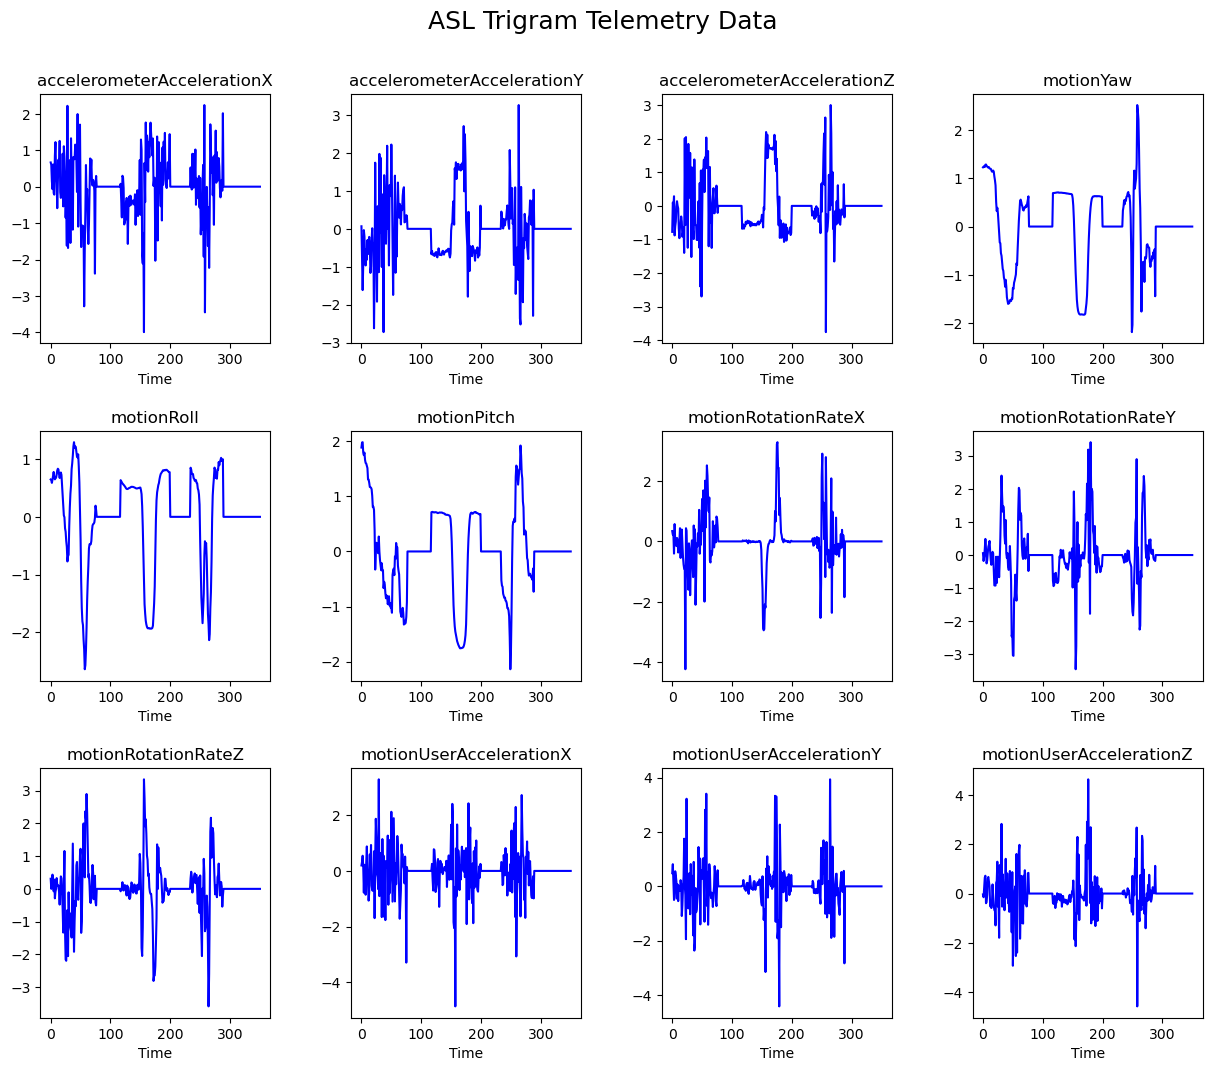

In [26]:
z = np.array(data[0]).T

#Getting dataframe to plot
df = pd.DataFrame(Y[2].T)
df.columns = features


#Splitting into units and feature name
units = []
names = []
for i in features:
    units.append(i[i.find("("):])
    names.append(i[:i.find("(")])
    

#Plotting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.35, wspace = 0.35)
fig.suptitle("ASL Trigram Telemetry Data", fontsize=18, y=0.95)

# loop through tickers and axes
for feature, name, unit, ax in zip(features, names, units, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df[feature].plot(ax=ax, color = 'blue')

    # chart formatting
    ax.set_title(name)
    #ax.get_legend().remove()
    #ax.set_ylabel(unit)
    ax.set_xlabel('Time')

plt.show()

## Words

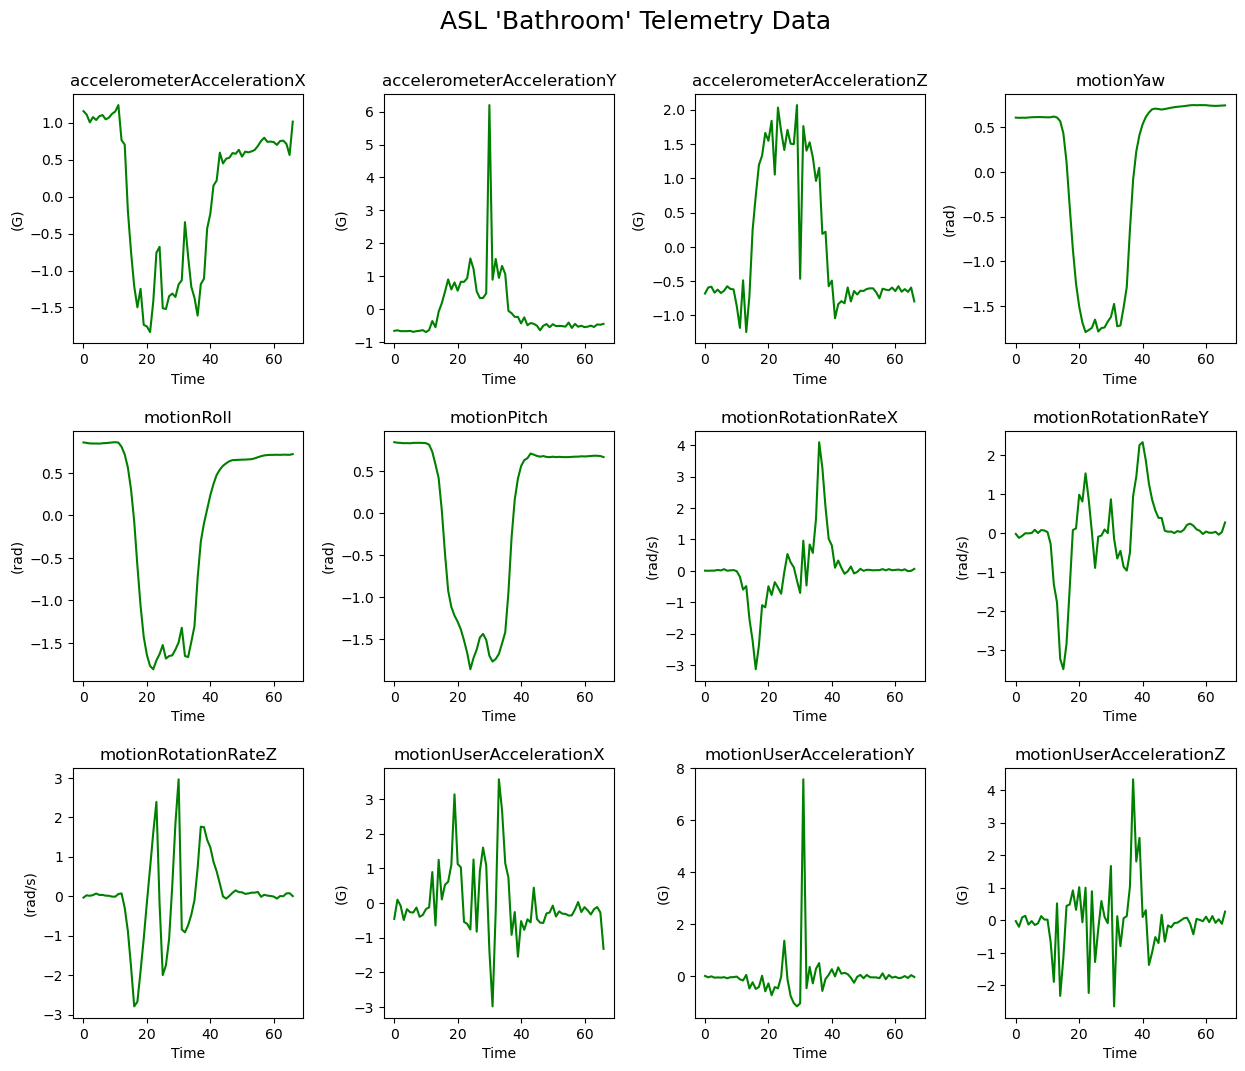

In [27]:
z = np.array(data_w[167]).T

#Getting dataframe to plot
df = pd.DataFrame(z.T)
df.columns = features_w


#Splitting into units and feature name
units = []
names = []
for i in features_w:
    units.append(i[i.find("("):])
    names.append(i[:i.find("(")])
    

#Plotting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.35, wspace = 0.35)
fig.suptitle("ASL 'Bathroom' Telemetry Data", fontsize=18, y=0.95)

# loop through tickers and axes
for feature, name, unit, ax in zip(features_w, names, units, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df[feature].plot(ax=ax, color = 'green')

    # chart formatting
    ax.set_title(name)
    #ax.get_legend().remove()
    ax.set_ylabel(unit)
    ax.set_xlabel('Time')

plt.show()

### Comparison Plot

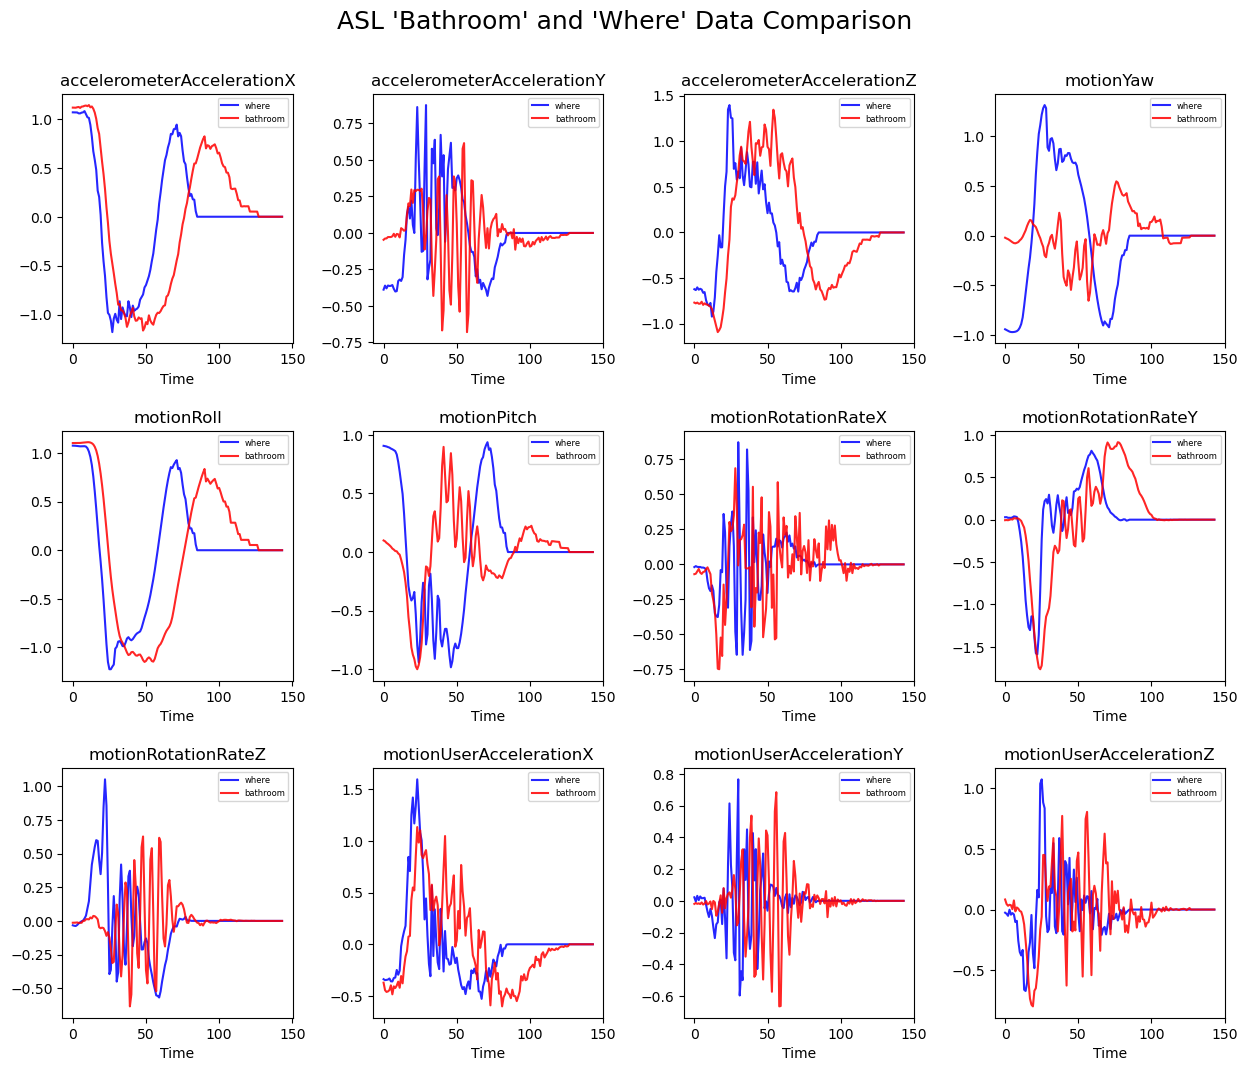

In [28]:

#Getting dataframe to plot
df = pd.DataFrame(z.T)
df.columns = features_w


#Splitting into units and feature name
units = []
names = []
for i in features_w:
    units.append(i[i.find("("):])
    names.append(i[:i.find("(")])
    

#Plotting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.35, wspace = 0.35)
fig.suptitle("ASL 'Bathroom' and 'Where' Data Comparison", fontsize=18, y=0.95)

# loop through tickers and axes
for feature, name, unit, ax in zip(features_w, names, units, axs.ravel()):


    data1 = 0
    word1 = "where"
    for i in list(np.where(target_w == word1)[0]):
        data1 += np.array(W[i][np.where(np.array(features_w) == feature)[0][0]])

    ax.plot(data1/len(list(np.where(target_w == word1)[0])), color = 'b', alpha = 0.85, label = word1)


    data2 = 0
    word2 = "bathroom"
    for i in list(np.where(target_w == word2)[0]):
        data2 += np.array(W[i][np.where(np.array(features_w) == feature)[0][0]])

    ax.plot(data2/len(list(np.where(target_w == word1)[0])), color = 'r', alpha = 0.85, label = word2)

    
    ax.set_title(name)
    #ax.set_ylabel(unit)
    ax.set_xlabel('Time')
    ax.legend(fontsize=6, loc ="upper right")

plt.show()

### Note
My work trying to deploy the model to the Apple Watch is not included here becuase I was not able to get it to work. I plan to continue working on this to try to make a function ASL Apple Watch app.